# Face recognition using k-Nearest Neighbor

---

### Contents
0. Yale Face Dataset A
1. Data Preprocessing
2. Principal Component Analysis
3. k-Nearest-Neighbor
4. Evaluation of the Key Parameters used for the max. Performance
5. Further Analysis

<i> Note: To keep the notebook readable, it focuses on executing the code and showing results, evaluation and further analysis. The entire code can be found in the functions folder and the beloging .py files.
In Section 1-3 the model runs for demonstration, using optimized parameters based on the evaluation section 4. Section 5 focuses on Yale Face Dataset B.</i>

---

### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

---
## 0. Yale Face Dataset A

The used *Yale Face Dataset A* contains 165 gray scale .gif files of uniform size (320 x 243 pixels) includes 15 individuals (14 men, 1 woman) with varying facial expressions and lighting conditions (*center-light, w/glasses, happy, left-light, w/o glasses, normal, right-light, sad, sleepy, surprised, and wink*).

Originally published in 1997 at the Yale University's Center for Computational Vision and Control in the scientific paper "Eigenfaces vs. Fisherfaces: recognition using class specific linear projection", it is now used in research for facial recognition, PCA and further models. Due to the easy perspective and generell lightning settings, even simple and basic face recognition models can be used to analyize the dataset, making it possible to get a glimpse at the broad spectrum of image analysis without having years of experience in this scientific field of research.

In [ ]:
img = Image.open("dataA/Yale_Face_Dataset_A.ppm.png")
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Yale Face Dataset A")
plt.axis("off")
plt.show()

---

## <a id="data-preprocessing"></a> 1. Data Preprocessing

In the first part, we perform different preprocessing steps before we can move on to Principal Component Analysis (PCA).
First, we transform each image into a 1D vector to create a 2D data matrix where each row is a single sample (image) and each column corrresponds to one feature (pixel). This procedure is called <b> flattening</b>. Secondly, we <b> convert the integer formats to floating point</b> so that arithmetic operations behave correctly and <b> normalize </b> the data to the range [0,1] to ensure that each pixel has a similar scale.

Before performing further preprocessing steps, we split the dataset into training and test data. The dataset contains 11 images of different facial expressions and light conditions of 15 subjects each. In order to split these images, 8 images of each subject are choosen randomly to use for training. All remaining images will serve as test data.
Lastly, we <b> standardize</b> the data by subtracting the mean and then dividing by the standard deviation for each feature (also called <b> Z-Transformation</b>).

In [2]:
from functions.preprocessing import preprocessing

# Path to the dataset folder. os.getcwd() gets the current working directory (in our case main.ipynb).
# If the dataset folder is one level up from the current working directory,  use "../" before "datasets".
folder_path = os.path.join(os.getcwd(), "dataA")
seed = 527
split_tt_ratio = 8/11

final_train, train_labels, final_test, test_labels, test_arr = preprocessing(folder_path, seed, split_tt_ratio)

Total training images: 120
Total testing images: 45


---

## <a id="pca"></a> 2. Pricinpal Component Analysis

*Principal Component Analysis* is a frequently employed technique in machine learning and statistics for the management of high-dimensional data. This approach involves the reduction of data and the subsequent focus on the principal components that account for the maximum proportion of variance. After pre-processing our data, we have now entered all the information from the images into a matrix with the following dimensions [120, 77760] and [45, 77760]. However, since we want to use the k<sub>NN</sub> method to compare and assign individual pixels of each image, we must limit ourselves to the essential, meaningful (**principal components**). This dimensionality reduction is justified by the fact that only a few principal components are often sufficient to capture the essential structure of high-dimensional image data. For example, in the context of face recognition, it has been shown that approximately 40 principal components ("eigenfaces") are enough to obtain a very good representation of the entire image dataset (Turk & Pentland, 1991).

By applying **Singular Value Decomposition (SVD)**, a mathematical operation for decomposing a matrix into orthogonal basis vectors, we identify the principal components of our dataset (highest variance explained by the eigenvalues). These components allow us to project the high-dimensional image data into a lower-dimensional space while preserving as much of the original variance as possible.

In practice, we apply SVD to our data matrix to compute a lower dimensional projection matrix, in which we project our preprocessed train and test data. It is important to consider how much explained variance is needed to increase the accuracy of the model without increasing the required computing power, for our model this threshold was **26 PCs** with an explained variance of ~ 90%.

In [3]:
from functions.pca import svd_pca
from functions.pca import pca_transform

n_components = 26

projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train,n_components)

test_reduced = pca_transform(final_test,projection_matrix)


Succesfully reduced matrix from (120, 77760) to (120, 26)

Succesfully transformed matrix from (45, 77760) to (45, 26)


---

## <a id="knn"></a> 3. k-Nearest-Neighbor

Following the transformation of the data into a more processable format, the next step is to initiate the facial recognition process. The k<sub>NN</sub> algorithm is a simple, non-parametric method which is used for classification and regression. In our case, we use it to classify the test data based on its similarity to the known training examples.

As each preprocessed test image is projected into the reduced space, the (euclidean) distance is measured between its position and the k-nearest neighbours of training images. As a result, the analyzed test data point is assigned to one of the subject clusters 1-15, whose predefined training data is most frequently below the nearest neighbors.

The parameter **k** must be chosen such that enough neighbors are considered to avoid the influence of outliers, but not so many that the decision becomes too generalized or blurred by irrelevant data points. As section 4 of the notebook analyzes in more detail, the model runs most accurately with the calculated distance to the nearest **3** neighbors and the subsequent assignment.

### Model Performance

The output of the k<sub>NN</Sub> algorithm also represents the final result of our project. Each test image is assigned to a subject based on its distance to the k nearest neighbors in the training set. This assignment is stored as the prediction. All predictions for the test set are then compared to the corresponding true labels. The final output — **the accuracy** — is calculated as the ratio of correctly predicted labels to the total number of test samples.

**Accuracy** = $\frac{\text{correct predictions}}{\text{total predictions}}$

After several testing rounds our accuracy is located between 75% und 80%. This fluctuation appears, as the algorithm sometimes correclty assignes 1 or 2 images more compared to the other rounds.

We created a confusion matrix to show, which images were wrongly assigned. On the diagonal of the matrix the amount of correct predictions per subject is observed. The colorbar indicates which color belongs to which amount of predictions per subject. A blue color outside of the diagonal means, that one (or more) images were assigned to the wrong subject.


k-NN Classification Accuracy: 77.78%


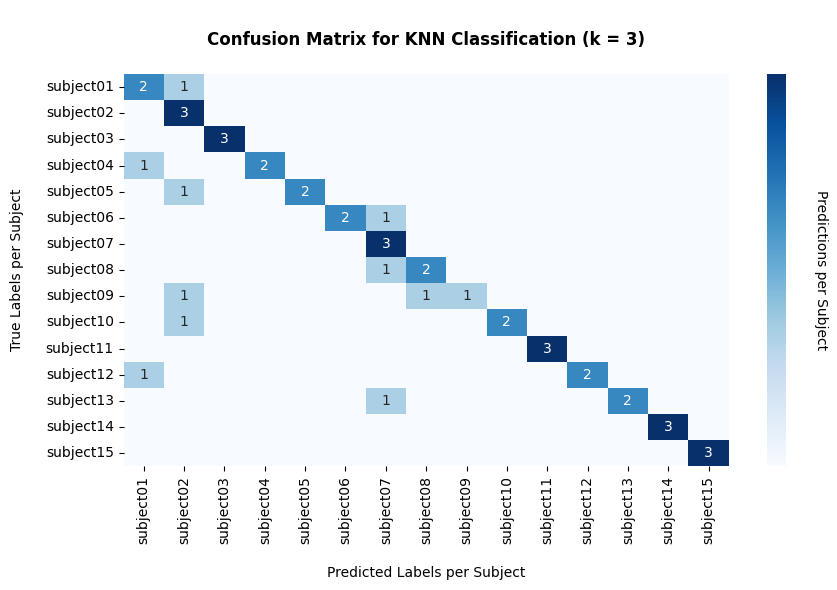

In [4]:
from functions.knn import knn_classifier

# Number of neighbors to consider
k = 3
predictions, acc = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k)

# Convert them to NumPy arrays:
true_labels = np.array(test_labels)
pred_labels = np.array(predictions)

# Compute the confusion matrix (shape: n_classes, n_classes)
cm = confusion_matrix(true_labels, pred_labels)

# Determine unique class labels for better tick labeling
classes_labels = np.unique(np.concatenate((true_labels, pred_labels)))

# Create an annotation matrix with empty strings where value is 0
annot = np.where(cm != 0, cm.astype(str), "")

plt.figure(figsize=(9, 6))
heatmap = sns.heatmap(cm, cmap="Blues", annot=annot, fmt="",xticklabels=classes_labels, yticklabels=classes_labels)

# Customize the colorbar annotations
cbar = heatmap.collections[0].colorbar
# Set specific tick positions
cbar.set_ticks([]) 
# Labelpad is used to adjust the distance of the label from the colorbar
cbar.set_label("Predictions per Subject", rotation=270, labelpad=30)

plt.xlabel('\nPredicted Labels per Subject')
plt.ylabel('True Labels per Subject\n')
plt.title(label="\n")
plt.title(label=f"\nConfusion Matrix for KNN Classification (k = {k})\n", fontweight='bold')
plt.tight_layout()
# plt.savefig("confusion_matrix_k3.svg")
plt.show()

Moreover, a *misclassified images plot* , as a basis for interpretation of the misclassification, was created. The plot shows that light conditions as well as glasses are hard to assign correctly. We ran the algorithm several times. The female subject's images (Subject 11) were correclty assigned in each round, indicating that long hair is easy recognizable for the KNN Classifier. Furthermore, several subject images with right/left-light conditions were wrongly assigned to subject 3 (sometimes also other subjects), indicating again that light is a big limiting factor. To be able to compare and interpret the results we additionaly displayed the first image from each subject above the plot.

In [ ]:
# rescale images to the original size of the training images
image_height = 243
image_width = 320

original_images = []

for img_file in os.listdir(folder_path):

    img_path = os.path.join(folder_path, img_file)
    with Image.open(img_path) as img:
        img = np.array(img, dtype=np.float32)
        original_images.append(img)

original_shape_test_images = test_arr.reshape(-1, image_height, image_width)

# Determine misclassified indices
# zipping the true labels and predictions to find misclassified images
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predictions)) if true != pred]
# Print the number of misclassified images and their indices
print(f"Total misclassified images found: {len(misclassified_indices)}")
print(f"Image indices: {misclassified_indices}")

# Plot the first image of each subject from the original dataset
stand_images = [0, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154]

plt.figure(figsize=(15, 8))
plt.suptitle("Subject Images Dataset A", fontsize=16, fontweight="bold")

# Create a grid of 3 rows x 5 columns
rows, cols = 3, 5
for idx, img_index in enumerate(stand_images):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(original_images[img_index], cmap='gray')
    plt.axis('off')
    plt.title(f"\n\nSubject {idx+1}", fontsize=13)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Plotting up to 15 misclassified images (or fewer if not available)
num_to_plot = min(15, len(misclassified_indices))
# for this a plot with subplots is created
plt.figure(figsize=(12, 12))
plt.title("Misclassified Test Images Dataset A\n\n\n\n", fontsize=16, fontweight = "bold")
plt.axis("off")
for idx, mis_idx in enumerate(misclassified_indices[:num_to_plot]):
    plt.subplot(4,3, idx+1)
    plt.imshow(original_shape_test_images[mis_idx], cmap='gray')
    plt.title(f"\n\nPredicted: {predictions[mis_idx]}\n\nTrue:")
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Additionally we used KNeighborsClassifier, a build-in function by sklearn, to apply the KNN algorithm to our data and compare the outcome to our manually implemented Classifier. The accuracy scores differs in some rounds in ~ 3 %, as KNeighborsClassifier uses a different approach to handle tie problem (further discussed in section 4).

In [ ]:
knn = KNeighborsClassifier(3)
knn.fit(train_reduced, train_labels)
y_pred = knn.predict(test_reduced)

accuracy = accuracy_score(test_labels, y_pred)

print(f"k-NN Accuracy with sklearn function: {accuracy * 100:.2f}%")

---

## <a id="accuracy"></a> 4. Evaluation of the Key Parameters used for the max. Performance

### 4.1 How much Variance is explained by each PC?

First of all, we now want to define a threshold as a basis to decide how much pricipal components (PC) we want to include in our analysis. We decided to use 90 % of Variance hence **26** PCs, this should include enough information. The corresponding plot shows a horizontal asymptotic behavior and grows exponentionally at the beginning. With higher amount of PCs the curve still grows but at a slower rate. Choosing a "low" amount of PCs means also faster processing.

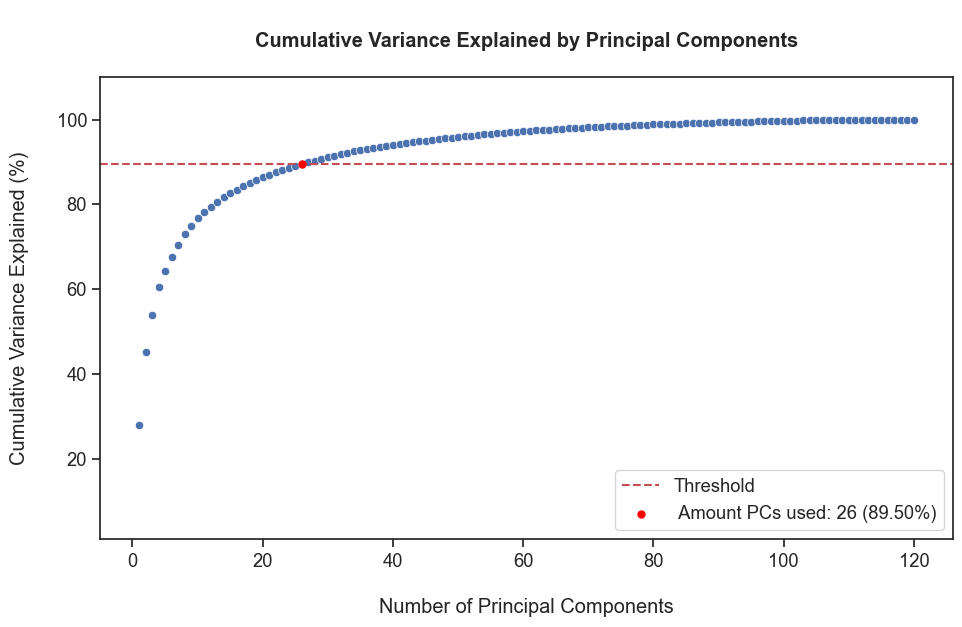

In [5]:
projection_matrix_for_plot, train_reduced_for_plot, explained_variance_ratio_for_plot = svd_pca(final_train,120, verbose = False)

# Range of components from 1 to 120
n_pcs_for_plot = np.arange(1, 121)

# times 100 to convert to percentage
cumulative_variance = np.cumsum(explained_variance_ratio_for_plot*100)

# We subtract 1 from n_components because python uses 0-based indexing
highlight_n_plot_y = cumulative_variance[n_components-1]

# Most of the following functions are used to create a good looking plot
# essential part of the plot is sns.scatterplot
# comments for the further plots were kept to a minimum, as they are similar to the previous plots
sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.scatterplot(x=n_pcs_for_plot, y=cumulative_variance, marker = "o")
plt.xlabel("\nNumber of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)\n")
plt.title(label="\nCumulative Variance Explained by Principal Components\n", fontweight='bold')
plt.axhline(y=highlight_n_plot_y, color='r', linestyle='--', label="Threshold")
plt.scatter(n_components, highlight_n_plot_y, color="red", s=25, zorder=2,
            label=f" Amount PCs used: {n_components} ({highlight_n_plot_y:.2f}%)")
plt.legend(loc = "lower right")
plt.ylim(1, 110)
plt.show()

### 4.2  Determining the Best Train/Test Data Ratio

For small datasets, the results may also depend on the way you choose to split the dataset. We need to use a certain amount of training images, so that the model recongnizes most of the unseen test images correctly. If no suffienct amount training data per subject is provided, KNN performs poorly, because not enough data was provided to learn, in our case to create sufficient cluster, where our images can be assigned to. Too much training data may also lead to poor results, especially for small datasets, as this can result in high variance and limited validation options.

Therefore, following plot shows the KNN accuracy for all possible Train/Test Ratios for different k from 1 to 5. The same random seed (Number 527) and same amount of PCs (26) was used. Note that discrete numbers are used, as we have excatly 9 different data splitting scenarios. Nevertheless, the datapoints were connected for visibility, as with a scatterplot, at some scenarios it would be hard to evaluate how high the accuracy for which k is.

In [ ]:
train_test_ratios = [1/11, 2/11, 4/11, 5/11, 6/11, 7/11, 8/11, 9/11, 10/11]

# Store results for each k value separately
# This will hold multiple DataFrames for different k values
df_list = []

for k_split in range(1,6):
    # Reset accuracies for each k_split iteration
    train_test_accuracies = []
    # loop through the different train/test ratios
    for train_test_ratio in train_test_ratios:
        final_train_split, train_labels_split, final_test_split, test_labels_split, test_arr = preprocessing(folder_path, seed, train_test_ratio, verbose=False)

        projection_matrix_split, train_reduced_split, explained_variance_ratio_split = svd_pca(final_train_split, n_components, verbose=False)

        test_reduced_split = pca_transform(final_test_split, projection_matrix_split, verbose=False)

        predictions_split, accuracy_split = knn_classifier(train_reduced_split, train_labels_split, test_reduced_split, test_labels_split, k_split, verbose=False)
        train_test_accuracies.append(accuracy_split)

    df_split = pd.DataFrame({
        # Add k_split identifier
        "K Value": [k_split] * len(train_test_ratios),
        "Amount of Training Data (%)": [round(r * 100) for r in train_test_ratios],
        "KNN Accuracy per Train/Test Ratio (%)": [round(a * 100, 2) for a in train_test_accuracies]
    })
    # Store DataFrame for this k_split
    df_list.append(df_split)

# Append results to the combined DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Get the index of the highest accuracy
max_index_split = df_combined['KNN Accuracy per Train/Test Ratio (%)'].idxmax()

# Extract the best splitting and its accuracy
best_split = df_combined.loc[max_index_split, 'Amount of Training Data (%)']
highest_acc_split = df_combined.loc[max_index_split, 'KNN Accuracy per Train/Test Ratio (%)']

plt.figure(figsize=(11, 6))
sns.lineplot(data=df_combined, x="Amount of Training Data (%)",
              y="KNN Accuracy per Train/Test Ratio (%)",
              hue="K Value", palette = "viridis", marker="o")
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with different Training/Test Data Ratios per Subject\n", fontweight='bold')
plt.xlabel("\nAmount of used Training Data (%)")
plt.ylabel("KNN Accuracy per Train/Test Data Ratio (%)\n")
plt.ylim(0, 100)
plt.legend(title="k Values", ncol=3, loc= "lower right")
plt.tight_layout()
# plt.savefig("train_test_ratio_k1_k5.svg")
plt.show()

### 4.3 Determining the best k

Using build-in functions from sklearn, we want to find the best k by evaluating accuracy-, precision-, recall- and f1- score combined with K-Fold Cross Validation. This ensures that we choose our k with robust parameters, which is important for small datasets, as variance may affect the results. K-fold Cross Validation evaluates the model performance by splitting the dataset multiple times in training and validation sets. More precisely it splits the dataset into k subsets (folds), trains the model k times, each time using k-1 folds for training and 1 fold for testing and averages the results from all k runs to get a final performance score.

Stratified K-Fold, a specific type of K-Fold Cross Validation, is used to ensure class distribution remains balanced across folds, which is very important for classification tasks like face recognition. We train the model 5 times (5-fold), as this is widely used in scientific work (Diebold, F.X. (2014)). We use 120 training images for this approach (70/30 Splitting of our dataset), to have left 45 unseen test images, which showed, that the estimated parameter k truly perform well as shown in sections 1-3.

To determine k even better, further scores were determined, as mentioned in the beginning:

**Accuracy** = $\frac{\text{Correct Predictions}}{\text{Total Predictions}}$

- gives a general measure of correct predictions, could be misleading if classes are imbalanced

**Precision** = $\frac{\text{True Positives}}{\text{true positives + False Positives}}$

- indicates the reliability of positive predictions
- answers the question: *Of all the instances predicted as positive, how many are actually positive?*

**Recall** = $\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

- measures the model’s ability to identify all relevant positive instances
- answers: *Of all actual positive cases, how many did the model correctly detect?*

**F<sub>1</sub>-Score** = $ 2 \cdot \frac{\text{Precision} \ \cdot \ \text{Recall}}{\text{Precision + Recall}}$

- particularly useful in multi-class or imbalanced classification problems, where considering precision and recall separately might be misleading.
- ensures that both false positives and false negatives are accounted for

Combined, all of these metrics provide a more comprehensive evaluation of the amount of different k´s than just determine the accuracy alone by balancing different types of prediction errors.

In [ ]:
# Ignore the UserWarnings that accure because of the statisticaly instable results.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Candidate k values for the KNN classifier.
ev_k_values = range(1,11)

# List to gather results for each candidate k.
results_ev = []

# random_state is set for reproducibility.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=527)

# Loop over the candidate k values.
for k_val in ev_k_values:
    # Lists to store metric scores for each fold.
    fold_acc = []
    fold_prec = []
    fold_rec = []
    fold_f1 = []

    # Perform the cross-validation.
    for train_index, test_index in skf.split(train_reduced, train_labels):
        # Create training and testing splits based on the indices.
        X_train, X_test = train_reduced[train_index], train_reduced[test_index]
        y_train, y_test = np.array(train_labels)[train_index], np.array(train_labels)[test_index]

        # Initialize and train the KNN classifier with the current k.
        y_pred, y_acc = knn_classifier(X_train,y_train, X_test, y_test, k_val, verbose=False)

        # Compute evaluation metrics for the current fold.
        fold_acc.append(accuracy_score(y_test, y_pred))
        fold_prec.append(precision_score(y_test, y_pred, average="weighted", zero_division=0))
        fold_rec.append(recall_score(y_test, y_pred, average="weighted", zero_division=0))
        fold_f1.append(f1_score(y_test, y_pred, average="weighted", zero_division=0))

    # Compute mean scores across all folds.
    mean_acc = np.mean(fold_acc)
    mean_prec = np.mean(fold_prec)
    mean_rec = np.mean(fold_rec)
    mean_f1 = np.mean(fold_f1)

    # Append the results for the current k into our list as a dictionary.
    results_ev.append({
        "k": k_val,
        "accuracy": mean_acc,
        "precision": mean_prec,
        "recall": mean_rec,
        "f1": mean_f1
    })

# Convert the list of dictionaries into a Pandas DataFrame.
results_ev_k = pd.DataFrame(results_ev)
print(results_ev_k)

The results show, that k = 1 performs best considering all parameters. As k = 1 is very sensitive to noise (e.g. single outliers) and prediction is based on just the closest sample, minor variations in the dataset (like different train-test splits or seeds) can cause big changes in accuracy. Additionally, overfitting might also be a problem here.

Therefore we it would make sense to proceed with the other best k, k = 2. Nevertheless the following plot shows, that k = 3 has the highest KNN-Accuracy score for the test images from our dataset, next to k =  2. This shows that for real world output can differ from model evaluation techniques,  especially for small datasets. Therefore also accuracy percentages differ, which is due to the dataset size, as small changes in data distribution can significantly impact accuracy. Also Stratified k-Fold averages the results, meaning that it performs slightly better or worse in different folds and therefore may perform best with k = 3 in some rounds.

k = 1 was not considered in the plot due to the reasons mentioned before. k = 2 has the same accuracy as k = 3, but if we would use 2 second nearest neighbors, a tie problem might occur more frequently, meaning that the 2 nearest neighbors are equaly distanced from the new datapoint. We reduced this probability by choosing an odd number. Our KNN classifier handels this problem by choosing the cluster, in which the first nearest neighbor was determined, leading to fluctuation in accuracy.

Evaluation of best k for:
120 training images and 45 test images and 26 principal components

Best k = 2 with accuracy: 80.00%


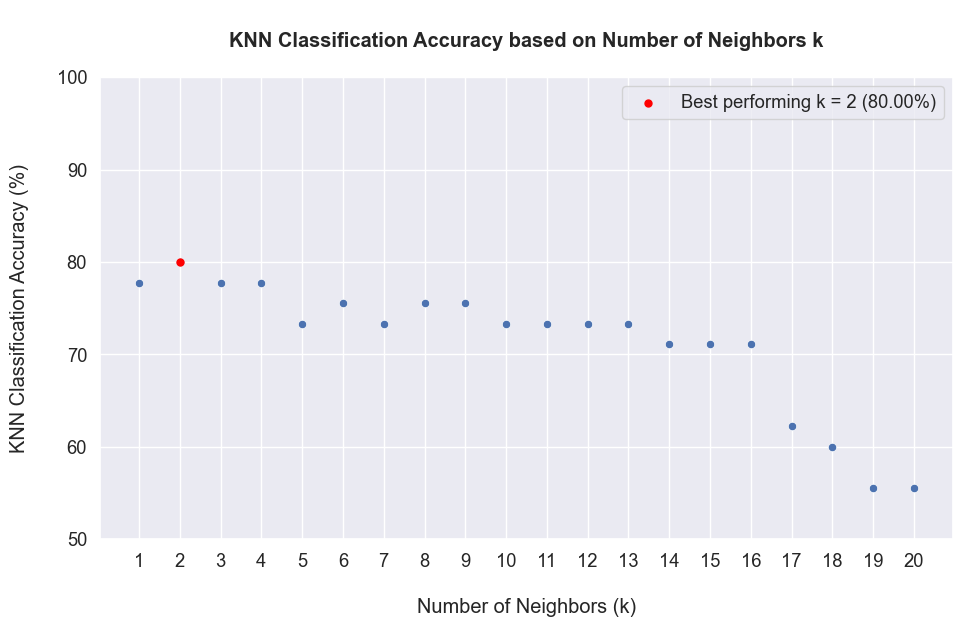

In [6]:
# Dictionary to store accuracies for each k value.
accuracy_dict = {}

#\033[1m stands for bold;\033[3m stands for italic \033[0m resets the formatting to normal.
print(f"Evaluation of best \033[3m\033[1mk\033[0m for:")
print(f"\033[3m\033[1m{len(train_reduced)}\033[0m training images and \033[3m\033[1m{len(test_reduced)}\033[0m test images and \033[3m\033[1m{n_components}\033[0m principal components")

# loop through k values from 1 to 20
for k in range(1, 21):
    predicted_labels, accuracy = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k, verbose=False)
    # assigns the value of accuracy to the key k in the dictionary accuracy_dict.
    # This means for each value of k (the number of neighbors in KNN), you store the corresponding classification accuracy.
    accuracy_dict[k] = accuracy

# Identify the best k value based on the highest accuracy
best_k = max(accuracy_dict, key=accuracy_dict.get)
highest_accuracy = accuracy_dict[best_k]*100
print(f"\nBest k = {best_k} with accuracy: \033[1m{highest_accuracy:.2f}%\033[0m")

# First, sort the dictionary keys (k values) for plotting in order.
k_values = sorted(accuracy_dict.keys())
k_accuracy_values = [accuracy_dict[k]*100 for k in k_values]


sns.set_theme(style="darkgrid", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.scatterplot(x=k_values, y=k_accuracy_values, marker='o')

plt.xlabel("\nNumber of Neighbors (k)")
plt.ylabel("KNN Classification Accuracy (%)\n")
plt.title(label="\nKNN Classification Accuracy based on Number of Neighbors k\n", fontweight='bold')
plt.scatter(best_k, highest_accuracy, color="red", s=25, zorder=2, label=f"Best performing k = {best_k} ({highest_accuracy:.2f}%)")
plt.legend()
plt.ylim(50, 100)
plt.xticks(np.arange(1,21, 1))
plt.show()

### 4.4 How to manipulate Data

While KNN is formally considered a machine learning algorithm, it does not involve a true learning process in the traditional sense. Instead of learning a model from the training data, it simply stores the data and bases predictions on similarity measures at inference time **(memory-based learning)**. This instance leads to severe side effects like the very high sensitivity to dataset composition and random train-test splits, especially when the dataset is small like ours.

To demonstrate this effect and provide a brief introduction to data sensitivity and manipulation, we examine how the model's classification accuracy varies when different random seeds are used for splitting the dataset into training and test subsets.

*Note: A random seed determines the reproducibility of randomized processes, such as data splitting, and can significantly influence the performance results in small or imbalanced datasets.*

In [ ]:
from functions.preprocessing import preprocessing

# Lets run the KNN classifier with different random seeds to see how the accuracy changes.
seeds = np.array(range(0,101))

accuracies_seed = []

for seed in seeds:
    final_train_seed, train_labels_seed, final_test_seed, test_labels_seed, test_arr = preprocessing(folder_path, seed, split_tt_ratio, verbose=False)

    projection_matrix_seed, train_reduced_seed, explained_variance_ratio_seed = svd_pca(final_train_seed, n_components, verbose=False)

    test_reduced_seed = pca_transform(final_test_seed, projection_matrix_seed, verbose=False)

    predictions_seed, accuracy_seed = knn_classifier(train_reduced_seed, train_labels_seed, test_reduced_seed, test_labels_seed, k=3, verbose=False)
    accuracies_seed.append(accuracy_seed)

df_seed = pd.DataFrame({
    'Seed': seeds,
    'KNN Accuracy per seed (%)': np.array(accuracies_seed) * 100
})


In [ ]:
# Get the index of the highest accuracy
max_index = df_seed['KNN Accuracy per seed (%)'].idxmax()

# Extract the best seed and its accuracy
best_seed = df_seed.loc[max_index, 'Seed']
highest_acc_seed = df_seed.loc[max_index, 'KNN Accuracy per seed (%)']

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_seed['KNN Accuracy per seed (%)'], whis=1.5, width=0.5)
# Overlay actual data points
sns.stripplot(y='KNN Accuracy per seed (%)', data=df_seed, color="black", alpha=0.4, jitter=True)
sns.set_theme(style="ticks")

plt.title("\nDistribution of KNN Accuracy Across Seed Numbers 1-100\n", fontweight='bold')
plt.ylabel("KNN Accuracy per Seed (%)\n")
plt.xticks(ticks=[])
plt.ylim(0, 100)
plt.annotate(
    f"Best seed: {best_seed} ({highest_acc_seed:.2f}%)",
    xy=(0, highest_acc_seed),
    xytext=(0.05, highest_acc_seed-1),
    color='black',
    fontsize=9,
    fontweight= "bold",
    bbox=dict(boxstyle="round,pad=0.3", fc="gold", ec="black", lw=1),
    ha="left"
)
plt.tight_layout()
# plt.savefig("Boxplot.svg")
plt.show()

### 4.5 Eigenface Method without the first 3 Principal Components

We already found the right amount of PCs ( n_components = 26), but for this evaluation we test the model without the first 3 components to see if they explain identitiy-related information or capture lighting variations that we want to avoid. Belhumeur *et al.* tested this approach and showed that removing the initial three principal components does improve the performance of the Eigenface method in the presence of lighting variation.


In [ ]:
from functions.knn import knn_classifier

# Exclude the first 3 components
train_reduced_wo_3 = train_reduced[:, 3:]  
test_reduced_wo_3 = test_reduced[:, 3:]

k = 3
predictions = knn_classifier(train_reduced_wo_3, train_labels, test_reduced_wo_3, test_labels, k)


print(f"\nShape of train_reduced_eigenfaces: {train_reduced_wo_3.shape}")
print(f"Shape of test_reduced_eigenfaces: {test_reduced_wo_3.shape}")

print(f"\nExplained variance of the first 3 components: {explained_variance_ratio_for_plot[:3]}")
print(f"Cumulative explained variance ratio of the first 3 components: {np.sum(explained_variance_ratio_for_plot[:3]*100):.2f}%")

To explore in detail, why these PCs have an impact on accuracy we plot all 3 PCs against each other:

In [ ]:
# Example PCA DataFrame with first few components
df_first_6 = pd.DataFrame(train_reduced[:, :6], columns=["PC1", "PC2", "PC3", "PC4","PC5","PC6"])


combinations_first_6 = [("PC1", "PC2"), ("PC1", "PC3"), ("PC2", "PC3"), ("PC4", "PC5"), ("PC4", "PC6"), ("PC5", "PC6")]

sns.set_theme(style="ticks")

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten to make iteration easy

for ax, (x, y) in zip(axes, combinations_first_6):
    sns.scatterplot(
        data=df_first_6,
        x=x,
        y=y,
        s=60,
        edgecolor="k",
        alpha = 0.6,
        ax=ax
    )
    ax.set_title(f"\n{x} vs {y}\n", fontweight = "bold")

plt.tight_layout(h_pad=2.0)
plt.show()

This scatterplot is the decisive factor in explanation why we leave the first 3 principal components out of our model. Principal components were designed to not be linear dependent to any other principal component, therefore a linear regression line would tell you directly that something went wrong. But there are other important aspects to keep track on, of which the recognition is not very intuitive. 
By scatterplotting two PCs, each datapoint represents one image projected into the PCA space. The axes (e.g., PC1 and PC2) indicate how much each image expresses the corresponding principal component. These components capture directions of maximum variance in the data — not necessarily the directions that are useful for distinguishing between people. 

In the "PC1 vs PC2" plot, an almost parabolic distribution can be recognized. Imagine taking pictures of the same person while rotating a light source around their face — the resulting images follow a continuous illumination manifold in PCA space. That curved shape reflects systematic pixel changes due to lighting, **not due to identity** (Belhumeur, 1997).

Compared to this, e.g. plot "PC4 vs PC5" shows a more diffuse cloud of the datapoint and almost an emergine cluster. This suggests that PCs 4 and 5 begin to capture individual differences — such as eye shape, nose structure, or other facial features — rather than lighting. In conlcusion, the following principal components 4, 5, etc. explaining less variance, but the variance they capture is more likely to be meaningful for classification.

By removing the first 3 components we can achieve a higher accuracy because the model just concentrates on the variance that captures rather crucial facial differences than noise (light conditions or different poses). 

---

## <a id="further-analysis"></a> 5. Further analysis

### 5.1 Yale Face Dataset B Analysis

We saw, that 165 images are not enough to properly evaluate our self written code. Provided with a file called *Yale_B_32x32.mat*, we applied our functions to 2414 images of 38 subjects with mostly 64 images per subject. All images have the size 32x32 pixels and are rotated to the right (see following plot). In addition the following truncated dataframe indicates, that some subjects (11 to 17) have one or more images less. The images from a subject differ in light conditions and facial expressions.


In [7]:
from functions.furtheranalysis import datasetB_loading

split_tt_ratio_B = 2173/2414

images_B, labels_B  = datasetB_loading()

# Create a DataFrame
df_B = pd.DataFrame(labels_B, columns=["label"])

# Count the occurrences
count_df_B = df_B["label"].value_counts().sort_index().reset_index()
count_df_B.columns = ["Subject", "Amount of images"]

print(count_df_B[8:19])

    Subject  Amount of images
8         9                64
9        10                64
10       11                60
11       12                59
12       13                60
13       14                63
14       15                62
15       16                63
16       17                63
17       18                64
18       19                64


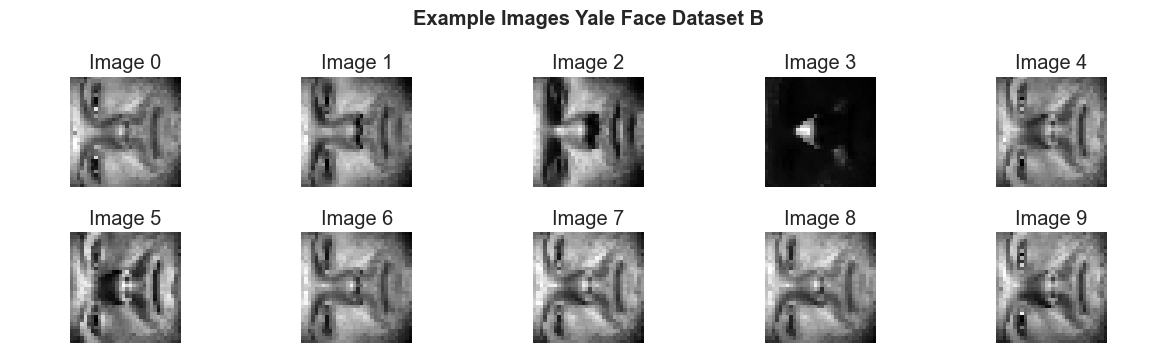

In [8]:
num_images = 10
num_cols = 5

# auto-calculate rows
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(12, 4))
plt.title("Example Images Yale Face Dataset B\n\n", fontweight= "bold")
plt.axis("off")

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images_B[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In order to apply PCA and KNN, we need to again to preprocess our data. As our data is stored differently and the corresponding labels are stored seperatly, we created a new preprocessing function escpecially for this dataset. It splits the dataset and the flattens, normalizes and standardizes the data. The outcome can be used in PCA and KNN without further adjustments.

In [9]:
from functions.furtheranalysis import preprocessing_dataset_B

final_train_B, train_labels_B, final_test_B, test_labels_B = preprocessing_dataset_B(images_B, labels_B, seed, split_tt_ratio_B)

Total training images: 2173
Total testing images: 241


1024 dimensions are to much to work with, therefore PCA reduces the dimension to 200 PCs. These PCs explain 98.64% of variance (see plot below). We tried different amounts of PCs and realized that up to 200 the K<sub>NN</sub>-Accuracy improves significantly. Looking at the Choosen PC Ratio, we choose ~20% of possible PCs for both datasets, indicating that this might be a good threshold.

In [10]:
from functions.pca import svd_pca
from functions.pca import pca_transform

n_components_B =  200

projection_matrix_B, train_reduced_B, explained_variance_ratio_B = svd_pca(final_train_B, n_components_B)

test_reduced_B = pca_transform(final_test_B,projection_matrix_B)



Succesfully reduced matrix from (2173, 1024) to (2173, 200)

Succesfully transformed matrix from (241, 1024) to (241, 200)


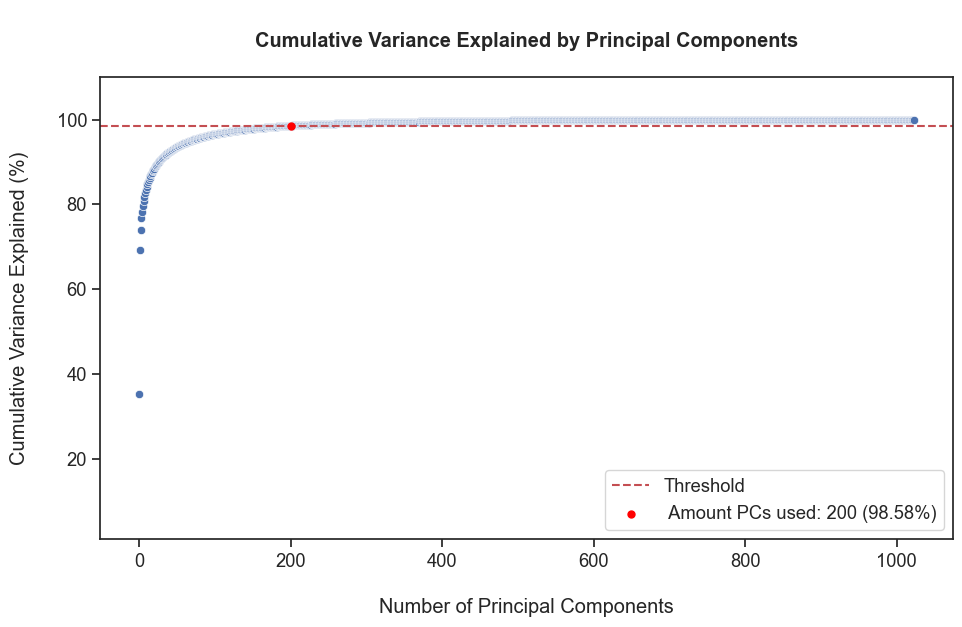

In [11]:
projection_matrix_for_plot_B, train_reduced_for_plot_B, explained_variance_ratio_for_plot_B = svd_pca(final_train_B, 1024, verbose = False)

# Range of components from 1 to 100
n_pcs_for_plot_B = np.arange(0, 1024)
# times 100 to convert to percentage
cumulative_variance_B = np.cumsum(explained_variance_ratio_for_plot_B*100)
# We subtract 1 from n_components because python uses 0-based indexing
highlight_n_plot_y_B = cumulative_variance_B[n_components_B-1]

# Most of the following functions are used to create a good looking plot
# essential part of the plot is sns.scatterplot
sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.scatterplot(x=n_pcs_for_plot_B, y=cumulative_variance_B, marker = "o")
plt.xlabel("\nNumber of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)\n")
plt.title(label="\nCumulative Variance Explained by Principal Components\n", fontweight='bold')
plt.axhline(y=highlight_n_plot_y_B, color='r', linestyle='--', label="Threshold")
plt.scatter(n_components_B, highlight_n_plot_y_B, color="red", s=25, zorder=2, 
            label=f" Amount PCs used: {n_components_B} ({highlight_n_plot_y_B:.2f}%)")
plt.legend(loc = "lower right")
plt.ylim(1, 110)
plt.show()

Next *knn_classifier* is used to assign unseen test images to one of the 38 subjects. We observe ~ 65 % Accuracy, which is suprisingly high, considering that Dataset B contains only 32x32 pixel images with lots of light variantion. 

In [15]:
from functions.knn import knn_classifier

k_B = 3
predictions_B = knn_classifier(train_reduced_B, train_labels_B, test_reduced_B, test_labels_B, k_B)

k-NN Classification Accuracy: 70.95%


To see, how Train/Test Data Ratios affect K<sub>NN</sub>-Accuracy for bigger datasets, we create the same lineplot as for Dataset A with k 1-5:

In [ ]:
train_test_ratios_B = [242/2414, 483/2414, 725/2414, 966/2414, 1207/2414, 1449/2414, 1690/2414, 1932/2414, 2173/2414]

# Store results for each k value separately
# This will hold multiple DataFrames for different k values
df_list_B = []

for k_split in range(1,6):
    # Reset accuracies for each k_split iteration
    train_test_accuracies_B = []
    # loop through the different train/test ratios
    for train_test_ratio_B in train_test_ratios_B:
        final_train_B, train_labels_B, final_test_B, test_labels_B = preprocessing_dataset_B(images_B, labels_B, seed, train_test_ratio_B,  verbose=False)
        
        projection_matrix_B, train_reduced_B, explained_variance_ratio_B = svd_pca(final_train_B, n_components_B, verbose=False)

        test_reduced_B = pca_transform(final_test_B,projection_matrix_B, verbose=False)

        predictions_B, accuracy_split_B = knn_classifier(train_reduced_B, train_labels_B, test_reduced_B, test_labels_B, k_split, verbose=False)
        train_test_accuracies_B.append(accuracy_split_B)

    df_split_B = pd.DataFrame({
        # Add k_split identifier
        "K Value": [k_split] * len(train_test_ratios_B),
        "Amount of Training Data (%)": [round(r * 100) for r in train_test_ratios_B],
        "KNN Accuracy per Train/Test Ratio (%)": [round(a * 100, 2) for a in train_test_accuracies_B]
    })
    # Store DataFrame for this k_split
    df_list_B.append(df_split_B)

# Append results to the combined DataFrame
df_combined_B = pd.concat(df_list_B, ignore_index=True)

# Get the index of the highest accuracy
max_index_split = df_combined_B['KNN Accuracy per Train/Test Ratio (%)'].idxmax()

# Extract the best splitting and its accuracy
best_split = df_combined_B.loc[max_index_split, 'Amount of Training Data (%)']
highest_acc_split = df_combined_B.loc[max_index_split, 'KNN Accuracy per Train/Test Ratio (%)']

plt.figure(figsize=(11, 6))
sns.lineplot(data=df_combined_B, x="Amount of Training Data (%)",
              y="KNN Accuracy per Train/Test Ratio (%)",
              hue="K Value", palette = "viridis", marker="o")
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with different Training/Test Data Ratios per Subject\n", fontweight='bold')
plt.xlabel("\nAmount of used Training Data (%)")
plt.ylabel("KNN Accuracy per Train/Test Data Ratio (%)\n")
plt.ylim(0, 100)
plt.legend(title="k Values", ncol=3, loc= "lower right")
plt.tight_layout()
# plt.savefig("train_test_ratio_k1_k5.svg")
plt.show()

The plot shows, that for bigger datasets, the splitting still affects our model results, but is more stable for different k values. In this case, a 90/10 Ratio can potentially be used, as 241 images would be available for testing.

Next, KNN-Classifier Performance is evaluated based on random seeds used to split the dataset. We again calculate  K<sub>NN</sub>-Accuracy for Seed Numbers 1-100:

In [ ]:
# Lets run the KNN classifier with different random seeds to see how the accuracy changes.
seeds = np.array(range(0,101))

accuracies_seed_B = []

for seed in seeds:
    final_train_B, train_labels_B, final_test_B, test_labels_B = preprocessing_dataset_B(images_B, labels_B, seed, split_tt_ratio_B,  verbose=False)
        
    projection_matrix_B, train_reduced_B, explained_variance_ratio_B = svd_pca(final_train_B, n_components_B, verbose=False)

    test_reduced_B = pca_transform(final_test_B,projection_matrix_B, verbose=False)

    predictions_B, accuracy_seed_B = knn_classifier(train_reduced_B, train_labels_B, test_reduced_B, test_labels_B, k_B, verbose=False)
    accuracies_seed_B.append(accuracy_seed_B)

df_seed_B = pd.DataFrame({
    'Seed': seeds,
    'KNN Accuracy per seed (%)': np.array(accuracies_seed_B) * 100
})

In [ ]:
# Get the index of the highest accuracy
max_index = df_seed_B['KNN Accuracy per seed (%)'].idxmax()

# Extract the best seed and its accuracy
best_seed = df_seed_B.loc[max_index, 'Seed']
highest_acc_seed = df_seed_B.loc[max_index, 'KNN Accuracy per seed (%)']

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_seed_B['KNN Accuracy per seed (%)'], whis=1.5, width=0.5)
# Overlay actual data points
sns.stripplot(y='KNN Accuracy per seed (%)', data=df_seed_B, color="black", alpha=0.4, jitter=True)
sns.set_theme(style="ticks")

plt.title("\nDistribution of KNN Accuracy Across Seed Numbers 1-100\n", fontweight='bold')
plt.ylabel("KNN Accuracy per Seed (%)\n")
plt.xticks(ticks=[])
plt.ylim(0, 100)
plt.annotate(
    f"Best seed: {best_seed} ({highest_acc_seed:.2f}%)",
    xy=(0, highest_acc_seed),
    xytext=(0.05, highest_acc_seed-1),
    color='black',
    fontsize=9,
    fontweight= "bold",
    bbox=dict(boxstyle="round,pad=0.3", fc="gold", ec="black", lw=1),
    ha="left"
)
plt.tight_layout()
# plt.savefig("Boxplot.svg")
plt.show()

We observe a narrower distribution compared to Dataset A, indicating that bigger dataset are less sensitive to random seeds.

Lastly we remove the first 3 PCs, to see if the accuracy improves for this dataset as well.

In [ ]:
train_reduced_B_wo_3 = train_reduced_B[:, 3:]  # Exclude the first 3 components
test_reduced_B_wo_3 = test_reduced_B[:, 3:]  # Exclude the first 3 components

k = 3
predictions_B = knn_classifier(train_reduced_B_wo_3, train_labels_B, test_reduced_B_wo_3, test_labels_B, k)

The accuracy improved ~ 20%, which again shows, that these PCs carry a lot of variance connected to light conditions. After plotting first principal components against each other, we recognize the a clear curved distribution  in PC1 vs PC2, PC2 vs PC3 and PC1 vs PC3. This consolidates the observations, that light conditions are stored in first 3 PCs, from Dataset A.

In [ ]:
# Example PCA DataFrame with first few components
df_first_6_B = pd.DataFrame(train_reduced_B[:, :6], columns=["PC1", "PC2", "PC3", "PC4","PC5","PC6"])


combinations_first_6_B = [("PC1", "PC2"), ("PC1", "PC3"), ("PC2", "PC3"), ("PC4", "PC5"), ("PC4", "PC6"), ("PC5", "PC6")]

sns.set_theme(style="ticks")

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten to make iteration easy

for ax, (x, y) in zip(axes, combinations_first_6_B):
    sns.scatterplot(
        data=df_first_6_B,
        x=x,
        y=y,
        s=60,
        edgecolor="k",
        alpha = 0.6,
        ax=ax
    )
    ax.set_title(f"\n{x} vs {y}\n", fontweight = "bold")

plt.tight_layout(h_pad=2.0)
plt.show()